In [1]:
import os, mne, socket
from mne_bids import BIDSPath, read_raw_bids

%matplotlib qt

# Get the hostname
hostname = socket.gethostname()

if 'hpc' in hostname:
    # You are running your code on HPC
    curr_dir = os.getcwd()
    path_parts = curr_dir.split(os.sep)
    dataPath = os.path.join(os.sep, 'scratch', 'work', 'courses', 'PSYCH-GA-3405-2024fa')
elif hostname == 'sebastian_mac':
    # You are Sebastian
    # Setting up paths for data
    mydir = os.getcwd()
    path_parts = mydir.split(os.sep)
    idcs = [i for i, c in enumerate(mydir) if c == os.sep]
    dataPath = mydir[:idcs[-2]]
else:
    # You are running on your device with Google drive path
    # Define the paths and initialize Fieldtrip
    my_user_id = 'mdd9787'  # change this to your netID
    curr_dir = os.getcwd()
    path_parts = curr_dir.split(os.sep)
    base_dir = os.path.join(os.sep, *path_parts[:3])
    dataPath = os.path.join(base_dir, 'Library', 'CloudStorage', f'GoogleDrive-{my_user_id}@nyu.edu', 'My Drive', 'Coursework', 'EEG MEG methods', 'ClassData')

eegRoot = os.path.join(dataPath, 'EEGBids')

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
## Load data
groupName = 'GroupD'  # Change group name to analyze different dataset (valid IDs: GroupA, GroupC, GroupD)
userName = 'mrugank'  # Make sure to ensure that you are writing to your derivatives 
taskName = 'oddball'

# Get subject code for your group
groupMap = {'GroupA': '001', 'GroupC': '003', 'GroupD': '004'}
subjCode = groupMap[groupName]

dataPath = os.path.join(eegRoot, f'sub-{subjCode}', 'eeg')
derivPath = os.path.join(eegRoot, 'derivatives', userName, 'preprocessing', f'sub-{subjCode}')

if not os.path.exists(derivPath):
    os.makedirs(derivPath)

saveRoot = f'sub-{subjCode}_task-{taskName}_'

# raw_clean.save(os.path.join(derivPath, f'{saveRoot}clean-raw.fif'), overwrite=True)
# Load raw_clean
raw_clean = mne.io.read_raw_fif(os.path.join(derivPath, f'{saveRoot}clean-raw.fif'))

Opening raw data file /Users/mrugankdake/Library/CloudStorage/GoogleDrive-mdd9787@nyu.edu/My Drive/Coursework/EEG MEG methods/ClassData/EEGBids/derivatives/mrugank/preprocessing/sub-004/sub-004_task-oddball_clean-raw.fif...
    Range : 0 ... 2055679 =      0.000 ...  4014.998 secs
Ready.
Opening raw data file /Users/mrugankdake/Library/CloudStorage/GoogleDrive-mdd9787@nyu.edu/My Drive/Coursework/EEG MEG methods/ClassData/EEGBids/derivatives/mrugank/preprocessing/sub-004/sub-004_task-oddball_clean-raw-1.fif...
    Range : 2055680 ... 2347007 =   4015.000 ...  4583.998 secs
Ready.


In [3]:
# ERP analysis
# Epoch data around the semantic visual stimulus
import numpy as np

# Apply low pass filter
raw_clean.load_data()
raw_clean.filter(l_freq=None, h_freq=15, n_jobs=-1)
# Convert annotations to events using these descriptions
events, event_dict = mne.events_from_annotations(raw_clean)

# Update duration in events
for i, evtIdx in enumerate(events):
    if evtIdx[2] not in [5, 6]:  # Skip events with code 5 or 6
        # Check if there is any event after that is not 5 or 6
        nextEvents = events[i+1:]
        # Check if there are any events after the current event that are not 5 or 6
        isNextEvent = False
        for nextEvt in nextEvents:
            if nextEvt[2] not in [5, 6]:
                isNextEvent = True
                break
        if isNextEvent:
            # Update duration
            events[i, 1] = nextEvt[0] - evtIdx[0]
        else:
            # Update duration
            events[i, 1] = raw_clean.times[-1] - evtIdx[0]

    else:
        # Check if there is any event after 
        nextEvents = events[i+1:]
        if len(nextEvents) > 0:
            events[i, 1] = nextEvents[0, 0] - evtIdx[0]
        else:
            events[i, 1] = raw_clean.times[-1] - evtIdx[0]

semantic_vis_blocks = events[events[:, 2] == 2] # 2 is the event code for semanticVis
semantic_aud_blocks = events[events[:, 2] == 3] # 3 is the event code for semanticAud

# Filter trial events ('even' and 'odd') that occur within semanticVis blocks
semantic_vis_events = []
semantic_aud_events = []
for event in events:
    if event[2] in [int(event_dict['even']), int(event_dict['odd'])]:
        # Check if the trial event occurs within any semanticVis block
        for block in semantic_vis_blocks:
            if block[0] <= event[0] <= block[0] + int(block[1]):  # Ensure event is within block duration
                semantic_vis_events.append(event)
                break

for event in events:
    if event[2] in [int(event_dict['even']), int(event_dict['odd'])]:
        for block in semantic_aud_blocks:
            if block[0] <= event[0] <= block[0] + int(block[1]):
                semantic_aud_events.append(event)
                break


# Convert to numpy array for creating epochs
semantic_vis_events = np.array(semantic_vis_events)
semantic_aud_events = np.array(semantic_aud_events)

# Create epochs from -2 to +3 seconds relative to each trial onset within the block
epochsVis = mne.Epochs(
    raw_clean,
    events=semantic_vis_events,
    event_id={'even': int(event_dict['even']), 'odd': int(event_dict['odd'])},
    tmin=-0.5,
    tmax=1,
    baseline=(None, 0),
    preload=True
)
epochAud = mne.Epochs(
    raw_clean,
    events=semantic_aud_events,
    event_id={'even': int(event_dict['even']), 'odd': int(event_dict['odd'])},
    tmin=-0.5,
    tmax=1,
    baseline=(None, 0),
    preload=True
)

Reading 0 ... 2347007  =      0.000 ...  4583.998 secs...
Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 451 samples (0.881 s)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:   18.0s finished


Used Annotations descriptions: ['/1', '/2', '/4', '/8', 'even', 'odd', 'storySeg']
Not setting metadata
540 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 540 events and 769 original time points ...
0 bad epochs dropped
Not setting metadata
450 matching events found
Setting baseline interval to [-0.5, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 450 events and 769 original time points ...
5 bad epochs dropped


In [4]:
import matplotlib.pyplot as plt

# Time-frequency decomposition via wavelet
frequencies = np.arange(4, 31, 1)
n_cycles =  3

# Time-frequency representation using Morlet wavelets
powerVis = mne.time_frequency.tfr_morlet(
    epochsVis,
    freqs=frequencies,
    n_cycles=n_cycles,
    return_itc=False,  # Only return power, not inter-trial coherence
    average=True,  # Average across trials
    n_jobs=-1
)

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:   58.8s finished


In [5]:
# Inspect the power spectrum for a single channel
plt.figure(figsize=(10, 6))
plt.imshow(
    powerVis.data[20],  # Change the index as needed for the desired channel
    aspect='auto',
    extent=[powerVis.times[0], powerVis.times[-1], powerVis.freqs[0], powerVis.freqs[-1]],
    origin='lower',
    interpolation='nearest'
)
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Representation for Channel 20')
plt.grid(False)
plt.show()

In [6]:
# Baseline correction
baseline = (-0.5, 0)
powerVis.apply_baseline(baseline=baseline, mode='logratio')  # 'logratio' is similar to 'relchange' in FieldTrip

power_dummy = powerVis.copy()

Applying baseline correction (mode: logratio)


In [7]:
# Plot the power spectrum
plt.figure(figsize=(10, 6))
plt.imshow(
    powerVis.data[20],  # Change the index as needed for the desired channel
    aspect='auto',
    extent=[powerVis.times[0], powerVis.times[-1], powerVis.freqs[0], powerVis.freqs[-1]],
    origin='lower',
    interpolation='nearest'
)
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Representation for Channel 20')
plt.grid(False)
plt.show()

Applying baseline correction (mode: mean)


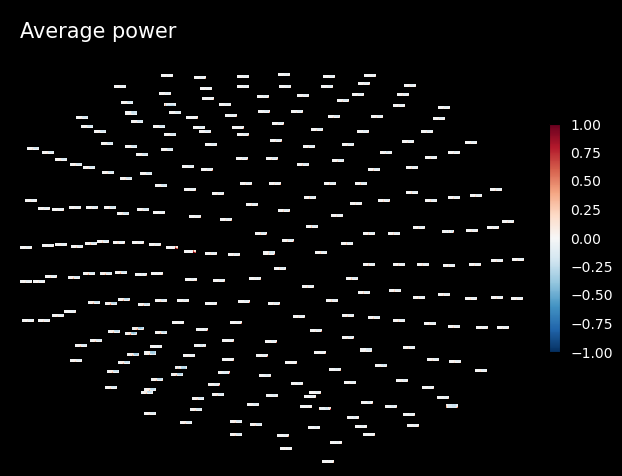

In [8]:
# Plot the distribution of power
powerVis.plot_topo(
    baseline=(-0.5, 0),
    title='Average power',
    vmin = -1,
    vmax = 1,
    )

In [9]:
# Using hanning window (single taper with fixed window length)
time_window = 0.15  # 0.5-second window
frequencies = np.arange(4, 31, 2)  
n_cycles = frequencies * time_window 

# Perform time-frequency analysis with Hanning window
powerVis = mne.time_frequency.tfr_morlet(
    epochsVis,
    freqs=frequencies,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=False,
    average=True,
    decim=1,
    n_jobs=-1
)

# Baseline correction
baseline = (-0.5, 0)
powerVis.apply_baseline(baseline=baseline, mode='logratio')  # 'logratio' is similar to 'relchange' in FieldTrip

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    6.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:    9.7s finished


Data type,Average Power Estimates
Data source,Epochs
Number of epochs,256
Dims,"channel, freq, time"
Estimation method,morlet
Number of channels,256
Number of timepoints,769
Number of frequency bins,14
Frequency range,4.00 – 30.00 Hz


In [10]:
# Inspect the power spectrum for a single channel
plt.figure(figsize=(10, 6))
plt.imshow(
    powerVis.data[20],  # Change the index as needed for the desired channel
    aspect='auto',
    extent=[powerVis.times[0], powerVis.times[-1], powerVis.freqs[0], powerVis.freqs[-1]],
    origin='lower',
    interpolation='nearest',
    vmin = -0.75,
    vmax = 0.75,
)
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Representation for Channel 20')
plt.grid(False)
plt.show()

Applying baseline correction (mode: mean)


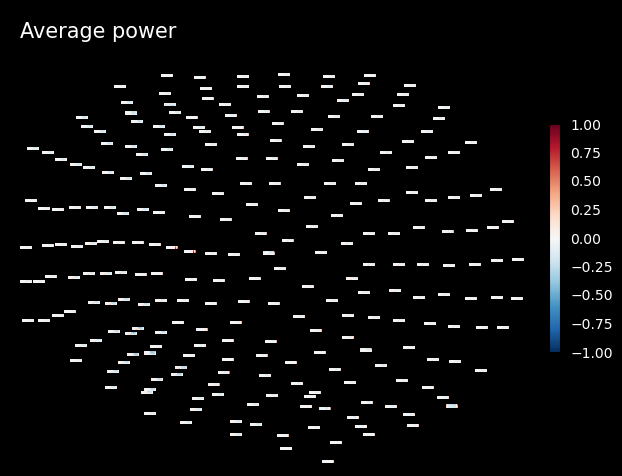

In [11]:
# Plot the distribution of power
powerVis.plot_topo(
    baseline=(-0.5, 0),
    title='Average power',
    vmin = -1,
    vmax = 1,
    )

In [12]:
## Multi-taper time-frequency analysis
frequencies = np.arange(4, 31, 2)  
n_cycles = 7.0 / frequencies  # Variable time window length: 5 cycles per frequency

# Perform DPSS multitaper TFR
powerVis_dpss = mne.time_frequency.tfr_multitaper(
    epochsVis,
    freqs=frequencies,
    n_cycles=n_cycles,
    time_bandwidth=2.0,  # DPSS with wider spectral smoothing (adjust as needed)
    use_fft=True,
    return_itc=False,
    average=True,
    decim=1,
    n_jobs=-1
)

# Baseline correction
baseline = (-0.5, 0)
powerVis_dpss.apply_baseline(baseline=baseline, mode='logratio')  # 'logratio' is similar to 'relchange' in FieldTrip

NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    6.0s


Applying baseline correction (mode: logratio)


[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:   11.4s finished


Data type,Average Power Estimates
Data source,Epochs
Number of epochs,256
Dims,"channel, freq, time"
Estimation method,multitaper
Number of channels,256
Number of timepoints,769
Number of frequency bins,14
Frequency range,4.00 – 30.00 Hz


In [13]:
# Inspect the power spectrum for a single channel
plt.figure(figsize=(10, 6))
plt.imshow(
    powerVis_dpss.data[20],  # Change the index as needed for the desired channel
    aspect='auto',
    extent=[powerVis_dpss.times[0], powerVis_dpss.times[-1], powerVis_dpss.freqs[0], powerVis_dpss.freqs[-1]],
    origin='lower',
    interpolation='nearest'
)
plt.colorbar(label='Power (dB)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Time-Frequency Representation for Channel 20')
plt.grid(False)
plt.show()

In [14]:
## Now let's compute Inter-trial phase coherence (ITPC)
frequencies = np.arange(4, 31, 1)  
n_cycles = frequencies / 2  # Morlet wavelet width similar to cfg.width=5 (adjustable)

# Compute the TFR with Morlet wavelets to get Fourier coefficients
power, itc = mne.time_frequency.tfr_morlet(
    epochsVis,
    freqs=frequencies,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,  # Directly compute inter-trial coherence
    average=True,  # Keep individual trials to compute ITC
    n_jobs=-1
)


NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.3s
[Parallel(n_jobs=-1)]: Done 256 out of 256 | elapsed:   21.2s finished


In [15]:
# Visualize the ITC
itc.plot([20],
    baseline=(-0.5, 0), mode='logratio', title="Inter-Trial Coherence (ITC)")
plt.show()

Applying baseline correction (mode: logratio)
